In [1]:
using Plots
using Random
using Distributions
using LinearAlgebra
include("pogm_restart.jl") # issues adding MIRT so will use julia file instead
rng = Random.seed!(0)
N = 500 # total points
D = 100 # ambient space
d = 10 # subspace rank
σ1 = 0.5 # noise level 1
σ2 = 10 # noise level 2
goodpts = 10 # good points out of total
window = 33 # size of range for coordinate data
X = zeros(D,N)
Y = zeros(D,N)
Π = vec(zeros(N,1))
U1 = svd(rand(D,N)).U[:,1:d]
for k = 1:N
    # older code projecting points U1*U1'*rand(Uniform(-100,100),D)
    X[:,k] =  U1*rand(Uniform(-33,33),d) 
    #X[:,k] =  U1*rand(Normal(0,19.05),d)
end
for j=1:N
        if (j<= goodpts)
            Y[:,j] = X[:,j] + rand(Normal(0,σ1),D)
            Π[j] = σ1^2
        else
            Y[:,j] = X[:,j] + rand(Normal(0,σ2),D)
            Π[j] = σ2^2
        end
end

In [2]:
XL = []
YL = []
for i = 1:10
    rng = Random.seed!(i)
    X0 = zeros(D,N)
    Y0 = zeros(D,N)
    for k = 1:N
    # older code projecting points U1*U1'*rand(Uniform(-100,100),D)
        X0[:,k] =  U1*rand(Uniform(-33,33),d) 
        #X0[:,k] =  U1*rand(Normal(0,19.05),d)
    end
    push!(XL,X0)
    for j=1:N
        if (j<= goodpts)
            Y0[:,j] = X0[:,j] + rand(Normal(0,σ1),D)
        else
            Y0[:,j] = X0[:,j] + rand(Normal(0,σ2),D)
        end
    end
    push!(YL,Y0)
end

In [3]:
function weightedPCA(Y , w, k)
    L = unique(w)
    Σ = zeros(size(Y)[1], size(Y)[1])
    for i=1:length(L)
        ind = findall(x -> x == L[i], w)
        Σ = Σ + L[i]*(Y[:,ind]*Y[:,ind]')
    end
    U = reverse(eigvecs(Σ), dims=2)
    Ȳ = reshape(shuffle(Y[:]), size(Y))
    U_Y = svd(Y).S
    U_Ȳ = svd(Ȳ).S
    #k = floor(Int, norm(U_Y .> U_Ȳ, 0))
    return U[:,1:k] #, k
end
U_WPCA = weightedPCA(Y,Π.^-1,d);

In [4]:
using HePPCAT
heppCAT_matrix = []
push!(heppCAT_matrix, Y[:,1:goodpts])
push!(heppCAT_matrix, Y[:,(goodpts+1):end])
heppCAT_nogroups = []
for i = 1:N
    push!(heppCAT_nogroups, Y[:,i])
end
homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
heppCAT = heppcat(heppCAT_matrix,d,1000;varfloor=1e-9)  
heppCAT_NOG = heppcat(heppCAT_nogroups,d,1000;varfloor=1e-9)
error_heppcat = norm(heppCAT.U*heppCAT.U' - U1*U1', 2)/norm(U1*U1', 2)
error_heppcat_NOG = norm(heppCAT_NOG.U*heppCAT_NOG.U' - U1*U1', 2)/norm(U1*U1', 2)
error_homoppca = norm(homoPCA.U*homoPCA.U' - U1*U1', 2)/norm(U1*U1', 2)
error_wpca = norm(U_WPCA*U_WPCA' - U1*U1', 2)/norm(U1*U1', 2)

0.18310451487901985

In [5]:
error_homoppca

0.34166276067111323

In [6]:
error_heppcat

0.25254411427613055

In [7]:
error_heppcat_NOG

0.2537450093428127

In [8]:
function HPCA_UNKNOWN_ADMM(Y, λr, N, μ, ρ, d, U_init)
    #X = zeros(size(Y))
    #Z = zeros(size(X))
    X = deepcopy(U_init*U_init'*Y)
    Z = deepcopy(Y-X)
    var = 0
    if (U_init == 0)
        #heppCAT_matrix = []
        #goodpts = 10
        #push!(heppCAT_matrix, Y[:,1:goodpts])
        #push!(heppCAT_matrix, Y[:,(goodpts+1):end])
        #var = heppcat(heppCAT_matrix,N,0).v[1]*vec(ones(size(Y)[2],1)) # homo pca
        var = vec(ones(100,1))
    else
        var = W_NO_GROUPS(Y,X)
    end
    Π = diagm(var.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-7) || (count <100))
    #for i = 1:1000
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        var = W_NO_GROUPS(Y,X)
        Π = diagm(var.^-1)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:d]   
    return U
end

function W_NO_GROUPS(Y, L)
    d = size(Y)[1]
    Π = diag((1/d)*(Y-L)'*(Y-L))
    Π = max.(Π,1e-9)
    return Π
end

function W_ALL_GROUPS(Y, L)
    Π = vec(zeros(size(Y)[2],1))
    d = size(Y)[1]
    goodpts = 5
    N = 100
    Π[1:goodpts] .= (1/(d*goodpts))*norm(Y[:,1:goodpts]-L[:,1:goodpts],2)^2
    Π[(goodpts+1):end] .= (1/(d*(N-goodpts)))*norm(Y[:,(goodpts+1):end]-L[:,(goodpts+1):end],2)^2
    Π = max.(Π,1e-9)
    return Π
end

W_ALL_GROUPS (generic function with 1 method)

In [865]:
λr = vcat(0:5:75)
error_hpca_admm = zeros(size(λr))
for i=1:length(λr)
    println(i)
    flush(stdout)
    U_HPCA = HPCA_UNKNOWN_ADMM(Y, λr[i], 10, 0.01, 1.01, d, homoPCA.U)  
    error_hpca_admm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


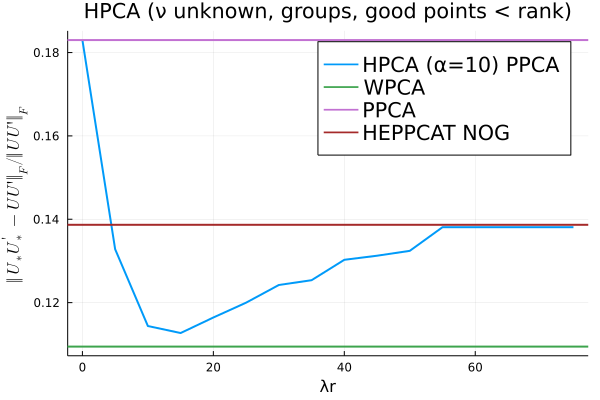

In [866]:
colors = theme_palette(:auto).colors;
using LaTeXStrings
plot(λr, error_hpca_admm, label="HPCA (α=10) PPCA", title="HPCA (ν unknown, groups, good points < rank)", xlabel="λr", ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F",linewidth=2, legendfontsize=14.0)
hline!([error_wpca],label="WPCA", linewidth=2, c=colors[3])
hline!([error_homoppca],label="PPCA", linewidth=2, c=colors[4])
hline!([error_heppcat_NOG],label="HEPPCAT NOG", linewidth=2, c=:brown)

In [218]:
# include("pogm_restart_original.jl")
# function HPCA_POGM(Y, λr, w, α, ϵ)
#     Π = w.^-1
#     Lf = maximum(Π)
#     Π = Diagonal(Π)
#     x0 = zeros(size(Y))
#     grad = K -> -1*(Y-K)*Π
#     soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
#     function pssvt(x,t,N)
#         U,S,V = svd(x)
#         S[(N+1):end] = soft.(S[(N+1):end],t)
#         return U*diagm(S)*V'
#     end
#     prox1 = (z,c) -> pssvt(z, c*λr, α)
#     W, _ = pogm_restart(x0, x -> 0, grad, Lf ; g_prox=prox1, niter=1000) # objective(x,Y-x,λr,w)
#     #U = svd(W).U[:,1:α]
#     return W
# end
# function AltMin(Y,λr,α,homoPCA_U)
#     X = homoPCA_U*homoPCA_U'*Y
#     X0 = deepcopy(X) .+ 1
#     Π = W_NO_GROUPS(Y,X)
#     #while (norm(X-X0)/norm(X) > 1e-6)
#     for i = 1:10
#         X0 = X
#         X = HPCA_POGM(Y,λr,Π,α,1e-1)
#         Π = W_NO_GROUPS(Y,X)
#     end
#     U = svd(X).U[:,1:α]
#     return U
# end

In [214]:
# λr = vcat(0.01:1:10)
# error_hpca_pogm = zeros(size(λr))
# for i=1:length(λr)
#     println(i)
#     flush(stdout)
#     U_HPCA = HPCA_POGM(Y, λr[i], Π, 10, 1e-6)  
#     error_hpca_pogm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
# end

In [217]:
# λr = vcat(1:1:10)
# error_hpca_pogm = zeros(size(λr))
# for i=1:length(λr)
#     println(i)
#     flush(stdout)
#     U_HPCA = AltMin(Y, λr[i], 10, homoPCA.U)  
#     error_hpca_pogm[i] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
# end

In [11]:
wpca_list = []
heppcat_list = []
homopca_list = []
hpca_list = []
#hpca_nuclear = []
λr = vcat(0.0:5:75.0)
λr[1] = 0.1
for i=1:10
    println(i)
    flush(stdout)
    homoPCA_U = svd(YL[i]).U[:,1:10]
    errorPCA = norm(homoPCA_U*homoPCA_U' - U1*U1',2)/norm(U1*U1',2)
    push!(homopca_list, errorPCA)
    U_WPCA = weightedPCA(YL[i],Π.^-1,d);
    errorWPCA = norm(U_WPCA*U_WPCA' - U1*U1',2)/norm(U1*U1',2)
    push!(wpca_list, errorWPCA)
    heppCAT_nogroups = []
    T = YL[i]
    for k = 1:N
        push!(heppCAT_nogroups, T[:,k])
    end
    heppCAT_NOG = heppcat(heppCAT_nogroups,d,1000;varfloor=1e-9)
    error_heppcat_NOG = norm(heppCAT_NOG.U*heppCAT_NOG.U' - U1*U1', 2)/norm(U1*U1', 2)
    push!(heppcat_list,error_heppcat_NOG)
    error_hpca_admm = zeros(size(λr))
    #error_hpca_nuclear = zeros(size(λr))
    for j=1:length(λr)
        U_HPCA = HPCA_UNKNOWN_ADMM(YL[i], λr[j], 10, 0.01, 1.01, d, homoPCA_U)  
        error_hpca_admm[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
        #U_HPCA = HPCA_UNKNOWN_ADMM(YL[i], λr[j], 0, 0.01, 1.01, d, homoPCA_U)  
        #error_hpca_nuclear[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
    end
    push!(hpca_list, error_hpca_admm)
    #push!(hpca_nuclear, error_hpca_nuclear)
end

1


LoadError: InterruptException:

In [973]:
heppcat_mean = mean(heppcat_list);
homopca_mean = mean(homopca_list)
wpca_mean = mean(wpca_list);
hpca_mean = mean(hpca_list);
hpca_mean_nuclear = mean(hpca_nuclear);

In [820]:
colors = theme_palette(:auto).colors

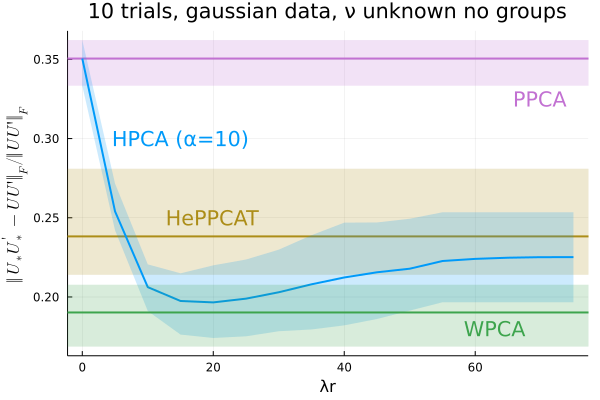

In [985]:
λr = vcat(0:5:75)
hline([homopca_mean],ribbon=(homopca_mean-minimum(homopca_list),maximum(homopca_list)-homopca_mean),c=colors[4], fillalpha = 0.2,linewidth=2, label="PPCA", legend=false)
hline!([heppcat_mean],ribbon=(heppcat_mean-minimum(heppcat_list),maximum(heppcat_list)-heppcat_mean), c=colors[5], fillalpha = 0.2, linewidth=2, label="HePPCAT")
maxValue = vec(maximum(reduce(vcat,transpose.(hpca_list)),dims=1))
minValue = vec(minimum(reduce(vcat,transpose.(hpca_list)),dims=1))
maxValue_nuc = vec(maximum(reduce(vcat,transpose.(hpca_nuclear)),dims=1))
minValue_nuc = vec(minimum(reduce(vcat,transpose.(hpca_nuclear)),dims=1))
#plot!(λr,hpca_mean, ribbon=(hpca_mean_nuclear .- minValue_nuc, maxValue_nuc .- hpca_mean_nuclear), fillalpha = 0.2, c=colors[1], linewidth=2, label="HPCA")
plot!(λr,hpca_mean, ribbon=(hpca_mean .- minValue, maxValue .- hpca_mean), fillalpha = 0.2, c=colors[1], linewidth=2, label="HPCA")
hline!([wpca_mean],ribbon=(wpca_mean-minimum(wpca_list),maximum(wpca_list)-wpca_mean), c=colors[3], linewidth=2,fillalpha = 0.2, label="WPCA")
plot!(xlabel="λr",ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F", title="10 trials, gaussian data, ν unknown no groups")
annotate!(70, 0.325, "PPCA", colors[4])
annotate!(20, 0.25, "HePPCAT", colors[5])
annotate!(15, 0.3, "HPCA (α=10)", colors[1])
annotate!(63, 0.18, "WPCA", colors[3])
#savefig("PAPER_FIGURE_UNKNOWN_NO_GROUPS_GAUSSIAN.pdf")

In [870]:
function HPCA_KNOWN_ADMM(Y, λr, w, N, μ, ρ)
    X = zeros(size(Y))
    Z = zeros(size(Y))
    Z = deepcopy(Y-X)
    Π = Diagonal(w.^-1)
    Λ2 = sign.(Y)
    Λ = deepcopy(Λ2 ./ (max(opnorm(Λ2), (1/λr)*norm(Λ2, Inf))))
    normY = norm(Y,2)
    count = 0
    soft = (x,t) -> sign.(x) .* max.(abs.(x) .- t, 0)
    function pssvt(x,t,N)
        U,S,V = svd(x)
        S[(N+1):end] = soft.(S[(N+1):end],t)
        return U*diagm(S)*V'
    end
    while ((norm(Y-X-Z,2)/normY > 1e-6) || (count <100))
        X = pssvt(Y-Z+(1/μ)*Λ, λr/μ,N)
        Z = μ*(Y-X+(1/μ)*Λ)*inv(Π+μ*I)
        Λ = Λ + μ*(Y-X-Z)
        μ = ρ*μ
        count = count + 1
    end
    U = svd(X).U[:,1:10]   
    return U
end

HPCA_KNOWN_ADMM (generic function with 1 method)

In [874]:
U_HPCA = HPCA_KNOWN_ADMM(Y, 50, Π, 10, 0.01, 1.01)
norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)

0.10943624206067484

In [988]:
wpca_list_known = []
heppcat_list_known = []
homopca_list_known = []
hpca_list_known = []
hpca_nuclear_known = []
λr = vcat(0:0.8:20)
λr2 = vcat(0:0.2:5)
for i=1:10
    println(i)
    flush(stdout)
    homoPCA_U = svd(YL[i]).U[:,1:10]
    errorPCA = norm(homoPCA_U*homoPCA_U' - U1*U1',2)/norm(U1*U1',2)
    push!(homopca_list_known, errorPCA)
    U_WPCA = weightedPCA(YL[i],Π.^-1,d);
    errorWPCA = norm(U_WPCA*U_WPCA' - U1*U1',2)/norm(U1*U1',2)
    push!(wpca_list_known, errorWPCA)
    
    heppCAT_matrix = []
    T = YL[i]
    push!(heppCAT_matrix, T[:,1:goodpts])
    push!(heppCAT_matrix, T[:,(goodpts+1):end])
    homoPCA = heppcat(heppCAT_matrix,d,0)   # init is homoscedastic PPCA
    knownvar = deepcopy(homoPCA)
    knownvar.v[1] = σ1^2
    knownvar.v[2] = σ2^2
    heppCAT_known = heppcat(heppCAT_matrix,d,1000;init=knownvar,vknown=true,varfloor=1e-9);
    error_heppcat = norm(heppCAT_known.U*heppCAT_known.U' - U1*U1', 2)/norm(U1*U1', 2)
    push!(heppcat_list_known, error_heppcat)
    
    error_hpca_known = zeros(size(λr))
    error_hpca_nuclear = zeros(size(λr))
    for j=1:length(λr)
        U_HPCA = HPCA_KNOWN_ADMM(YL[i], λr[j], Π, 10, 0.01, 1.01)  
        error_hpca_known[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
        U_HPCA = HPCA_KNOWN_ADMM(YL[i], λr2[j], Π, 0, 0.01, 1.01)  
        error_hpca_nuclear[j] = norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)
    end
    push!(hpca_list_known, error_hpca_known)
    push!(hpca_nuclear_known, error_hpca_nuclear)
end

1
2
3
4
5
6
7
8
9
10


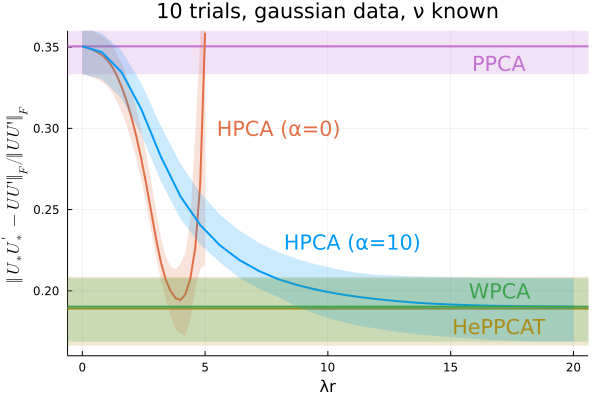

In [1001]:
heppcat_mean = mean(heppcat_list_known);
homopca_mean = mean(homopca_list_known)
wpca_mean = mean(wpca_list_known);
hpca_mean = mean(hpca_list_known);
hpca_mean_nuclear = mean(hpca_nuclear_known);

λr = vcat(0:0.8:20)
λr2 = vcat(0:0.2:5)
hline([homopca_mean],ribbon=(homopca_mean-minimum(homopca_list_known),maximum(homopca_list_known)-homopca_mean),c=colors[4], fillalpha = 0.2,linewidth=2, label="PPCA", legend=false)
hline!([heppcat_mean],ribbon=(heppcat_mean-minimum(heppcat_list_known),maximum(heppcat_list_known)-heppcat_mean), c=colors[5], fillalpha = 0.2, linewidth=2, label="HePPCAT")
maxValue = vec(maximum(reduce(vcat,transpose.(hpca_list_known)),dims=1))
minValue = vec(minimum(reduce(vcat,transpose.(hpca_list_known)),dims=1))
maxValue_nuc = vec(maximum(reduce(vcat,transpose.(hpca_nuclear_known)),dims=1))
minValue_nuc = vec(minimum(reduce(vcat,transpose.(hpca_nuclear_known)),dims=1))
plot!(λr2,hpca_mean_nuclear, ribbon=(hpca_mean_nuclear .- minValue_nuc, maxValue_nuc .- hpca_mean_nuclear), fillalpha = 0.2, c=colors[2], linewidth=2, label="HPCA")
plot!(λr,hpca_mean, ribbon=(hpca_mean .- minValue, maxValue .- hpca_mean), fillalpha = 0.2, c=colors[1], linewidth=2, label="HPCA")
hline!([wpca_mean],ribbon=(wpca_mean-minimum(wpca_list_known),maximum(wpca_list_known)-wpca_mean), c=colors[3], linewidth=2,fillalpha = 0.2, label="WPCA")
plot!(xlabel="λr",ylims=(0.16,0.36),ylabel=L"\Vert U_{*} U_{*}^{'}- UU' \Vert_F/ \Vert UU' \Vert_F", title="10 trials, gaussian data, ν known")
annotate!(17, 0.34, "PPCA", colors[4])
annotate!(17, 0.178, "HePPCAT", colors[5])
annotate!(11, 0.23, "HPCA (α=10)", colors[1])
annotate!(8, 0.3, "HPCA (α=0)", colors[2])
annotate!(17, 0.2, "WPCA", colors[3])
#savefig("PAPER_HPCA_KNOWN_GAUSSIAN.pdf")

In [918]:
U_HPCA = HPCA_KNOWN_ADMM(YL[5], 5, Π, 0, 0.01, 1.01)  
norm(U_HPCA*U_HPCA' - U1*U1',2)/norm(U1*U1',2)

0.35728791420659656